# ESTUDIO DEL Nº DE DETECCIONES

Si sólamente nos limitamos a comparar el nº de copias de los distintos elementos génicos (sea relativo o no) estamos perdiendo una información esencial: las diferencias claras en el nº de ARGvMGE detectados entre plásticos y controles. Esta diferencia, que observámos por primera vez en el diagrama de Venn, merece ser estudiada más a detalle.

De primeras, se me ocurre visualizarla de dos maneras: 
- Diagramas de Venn cuyo volumen cambie con el valor de cada área
- Diagramas de barras

También hay que considerar el hecho de que quizás interese más representar el % de ARGvMGE detectados sobre el total de presentes en el test en vez de el simple nº de amplificaciones positivas que haya habido. <mark> Por el momento, represento ambos valores por separado para escoger cuando llegue el momento </mark>

**Cabe mencionar que SÍ que se pueden llevar a cabo pruebas estadísticas que permitan demostrar diferencias entre el nº de amplificaciones si en vez de intentar hacerlo a nivel de secuencia individual (n = 1), pliego la información a nivel de, por ejemplo, familia de antibióticos**


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import scikit_posthocs as sp
from matplotlib_venn import venn2, venn2_circles
import numpy as np
import warnings
warnings.filterwarnings("ignore") #es una pesadez si no

In [3]:
# El df con todos los datos. Me interesa preservarlo para saber el total de cada variable
amp_data = pd.read_csv("../data/resistome_data/clean_data/ab_data_simple.csv", index_col = 0)
amp_data = amp_data[(amp_data.Assay != "aadA7") & (amp_data.sample != 5)]
#amp_data.loc[amp_data["antib"] == "Fluoroquinolone"]

amp_data.head()

,Assay,antib,sample,Ct,place,type_f,type_g,or_seq,rel_n,rel_16,rel_ab,log_n
0,aacC2,Aminoglycoside,25.0,23.78,ardley,PUR,plastic,arg,9.246982,63533.093185,0.000146,-3.837
1,aacC2,Aminoglycoside,27.0,22.51,ardley,PUR,plastic,arg,22.233099,47206.304126,0.000471,-3.327
2,aacC2,Aminoglycoside,20.0,25.91,ardley,soil,control,arg,2.123244,30549.211132,0.000070,-4.158
3,aacC2,Aminoglycoside,22.0,24.56,ardley,EPS,plastic,arg,5.395106,25882.129152,0.000208,-3.681
4,aacA/aphD,Aminoglycoside,25.0,26.05,ardley,PUR,plastic,arg,1.927525,63533.093185,0.000030,-4.518


Lo primero que tengo que hacer es conseguir el nº total de cada test: el nº total de pruebas de ARG, el nº total de pruebas de MGE, y el nº total de pruebas de ARGvMGE de cada familia determinada. No me es necesario extraer el nº total de pruebas llevadas a cabo a nivel de secuencia individual porque ya me la sé: tantas como muestras control/muestrás plástico haya

In [4]:
# Primero sacar el total general
rep_info = {}

total_arg = len(amp_data.loc[amp_data["or_seq"] == "arg"]["Assay"].unique())
total_mge = len(amp_data.loc[amp_data["or_seq"] == "mge"]["Assay"].unique())

rep_info["arg"] = total_arg
rep_info["mge"] = total_mge

general_reps_df = pd.DataFrame.from_dict(rep_info, orient = "index", columns = ["total_reps"])

del total_arg
del total_mge
del rep_info

general_reps_df

,total_reps
arg,309
mge,70


In [5]:
# Luego sacar el total de cada familia
rep_info = {} 
for target in amp_data["antib"].unique():
    total_target = len(amp_data.loc[amp_data["antib"] == target]["Assay"].unique())
    rep_info[target] = total_target

target_reps_df = pd.DataFrame.from_dict(rep_info, orient = "index", columns = ["total_reps"])

del rep_info
del total_target
del target

target_reps_df.head()

,total_reps
Aminoglycoside,60
Amphenicol,9
Vancomycin,24
Beta Lactam,54
MDR,43


Ya tengo ambos df, por lo que solo resta rehacer los de cada caso y juntarlos todos. O dicho de otro modo, empiezo a analizar.

## COMPARATIVA DEL Nº DE DETECCIONES EN PLÁSTICO VS CONTROL

In [6]:
# Reciclo código de la hoja de comparación del nº de copias. No tengo porqué amputar amp_data porque al tener
# NaN en las casillas que no amplifica, no pasa ningún filtro
rep_info = {} 
for target in amp_data["or_seq"].unique():
    seq_data = amp_data[(amp_data["or_seq"] == target)]
    control_seqs = set(seq_data.loc[(seq_data["type_g"] == "control")]["Assay"])
    plastic_seqs = set(seq_data.loc[(seq_data["type_g"] == "plastic")]["Assay"])
    control_reps = len(control_seqs - plastic_seqs)
    plastic_reps = len(plastic_seqs - control_seqs)
    both_reps = 0
    grouped_seqs = seq_data.groupby("Assay")
    for name, group in grouped_seqs:
        if len(group["type_g"].unique()) == 2: both_reps += 1
    rep_info[target] = (control_reps, plastic_reps, both_reps)

general_reps = pd.DataFrame.from_dict(rep_info, orient = "index", columns = ["control_reps", "plastic_reps", "both_reps"])

del rep_info
del plastic_reps
del control_reps
del seq_data
del target

general_reps = pd.concat([general_reps_df, general_reps], axis = 1)
del general_reps_df

general_reps

,total_reps,control_reps,plastic_reps,both_reps
arg,309,2,81,198
mge,70,0,17,47


Que podría visualizarse como

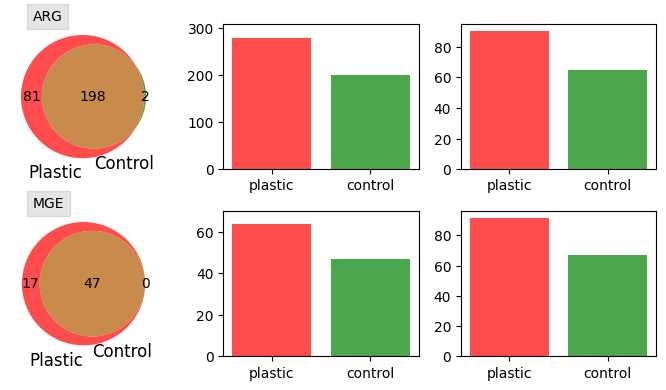

In [6]:
fig = plt.figure(figsize = (7,4))

left = -0.5
x_axis = ["plastic", "control"]
pos = 1

for cat in list(general_reps.index):
    #diagrama de venn
    ax = fig.add_subplot(2, 3, pos)
    venn2(subsets= ((general_reps.loc[cat]["plastic_reps"]), 
                    (general_reps.loc[cat]["control_reps"]),
                    (general_reps.loc[cat]["both_reps"])),
          set_labels=("Plastic", "Control"), 
          set_colors=("red", "green"), alpha=0.7)
    top = ax.get_ylim()[1] * 1.2
    txt = ax.text(left, top, s = cat.upper(), verticalalignment='top')
    txt.set_bbox(dict(facecolor='k', alpha=0.1))
    
    pos += 1 #mueve en la figura una posición
    
    #barplot de total
    ax = fig.add_subplot(2, 3, pos)
    ax.bar(x = x_axis, 
           height = [(general_reps.loc[cat]["plastic_reps"] + general_reps.loc[cat]["both_reps"]), 
                     (general_reps.loc[cat]["control_reps"] + general_reps.loc[cat]["both_reps"])],
           color = ["red", "green"], alpha = 0.7
          )
    ax.set_ylim(top = general_reps.loc[cat]["total_reps"])
    
    pos += 1
    
    #barplot de %
    ax = fig.add_subplot(2, 3, pos)
    ax.bar(x = x_axis, 
           height = [(((general_reps.loc[cat]["plastic_reps"] + general_reps.loc[cat]["both_reps"])*100)/general_reps.loc[cat]["total_reps"]), 
                     (((general_reps.loc[cat]["control_reps"] + general_reps.loc[cat]["both_reps"]) * 100) / general_reps.loc[cat]["total_reps"])
                    ],
           color = ["red", "green"], alpha = 0.7
          )
    
    pos += 1

fig.tight_layout()
plt.show()

## COMPARATIVA DEL Nº DE DETECCIONES EN PLÁSTICOS Y CONTROL POR DIANA

Como aquí hay muchos grupos, lo primero que veo necesario una vez se tenga la tabla es separar en ARG y MGE

In [8]:
# Misma historia para familias
#amp_data.dropna(inplace = True)
rep_info = {} 
for target in amp_data["antib"].unique():
    seq_data = amp_data[(amp_data["antib"] == target)]
    control_seqs = set(seq_data.loc[(seq_data["type_g"] == "control")]["Assay"])
    plastic_seqs = set(seq_data.loc[(seq_data["type_g"] == "plastic")]["Assay"])
    control_reps = len(control_seqs - plastic_seqs)
    plastic_reps = len(plastic_seqs - control_seqs)
    both_reps = 0
    grouped_seqs = seq_data.groupby("Assay")
    for name, group in grouped_seqs:
        if len(group["type_g"].unique()) == 2: both_reps += 1
    rep_info[target] = (control_reps, plastic_reps, both_reps)
    
    type_target = list(seq_data["or_seq"].unique())
    type_target = "".join(type_target)
    
    rep_info[target] = (control_reps, plastic_reps, both_reps, type_target)

family_reps = pd.DataFrame.from_dict(rep_info, orient = "index", 
                                     columns = ["control_reps", "plastic_reps", "both_reps", "or_seq"])

del rep_info
del plastic_reps
del control_reps
del seq_data
del target

family_reps = pd.concat([target_reps_df, family_reps], axis = 1)
#family_reps.drop("16S", inplace = True) #esto está aquí por accidente
del target_reps_df

#family_reps

Ahora separo en ARG y MGE

In [9]:
arg_data = family_reps[(family_reps["or_seq"] == "arg")]
mge_data = family_reps[(family_reps["or_seq"] == "mge")]

### COMPARATIVA DEL Nº DE DETECCIONES A NIVEL DE FAMILIA EN ARG

In [10]:
arg_data

,total_reps,control_reps,plastic_reps,both_reps,or_seq
Aminoglycoside,60,0,24,33,arg
Amphenicol,9,0,5,4,arg
Vancomycin,24,0,7,16,arg
Beta Lactam,54,0,13,34,arg
MDR,43,0,8,33,arg
Fluoroquinolone,11,0,2,8,arg
MLSB,46,1,7,34,arg
Phenicol,11,0,2,6,arg
Tetracycline,28,1,5,19,arg
Sulfonamide,6,0,2,3,arg


Antes de hacer las representaciones, es "necesario" quitar aquellos casos en los que el nº de amplificaciones es igual a en ambos casos, pues si no el programa representa un vacío blanco donde debieran estar (vamos, que quedan feos). No se puede hacer con ellos mas que decir que no se detectaron en ningún caso ni condición.

In [11]:
arg_clean = arg_data.loc[(arg_data["control_reps"] != 0 ) | (arg_data["plastic_reps"] != 0) | (arg_data["both_reps"] != 0)]
not_detected = set(arg_data.index) - set (arg_clean.index)

arg_data = arg_clean
print("The following antibiotic families: \n", not_detected, "\n were not detected")

The following antibiotic families: 
 set() 
 were not detected


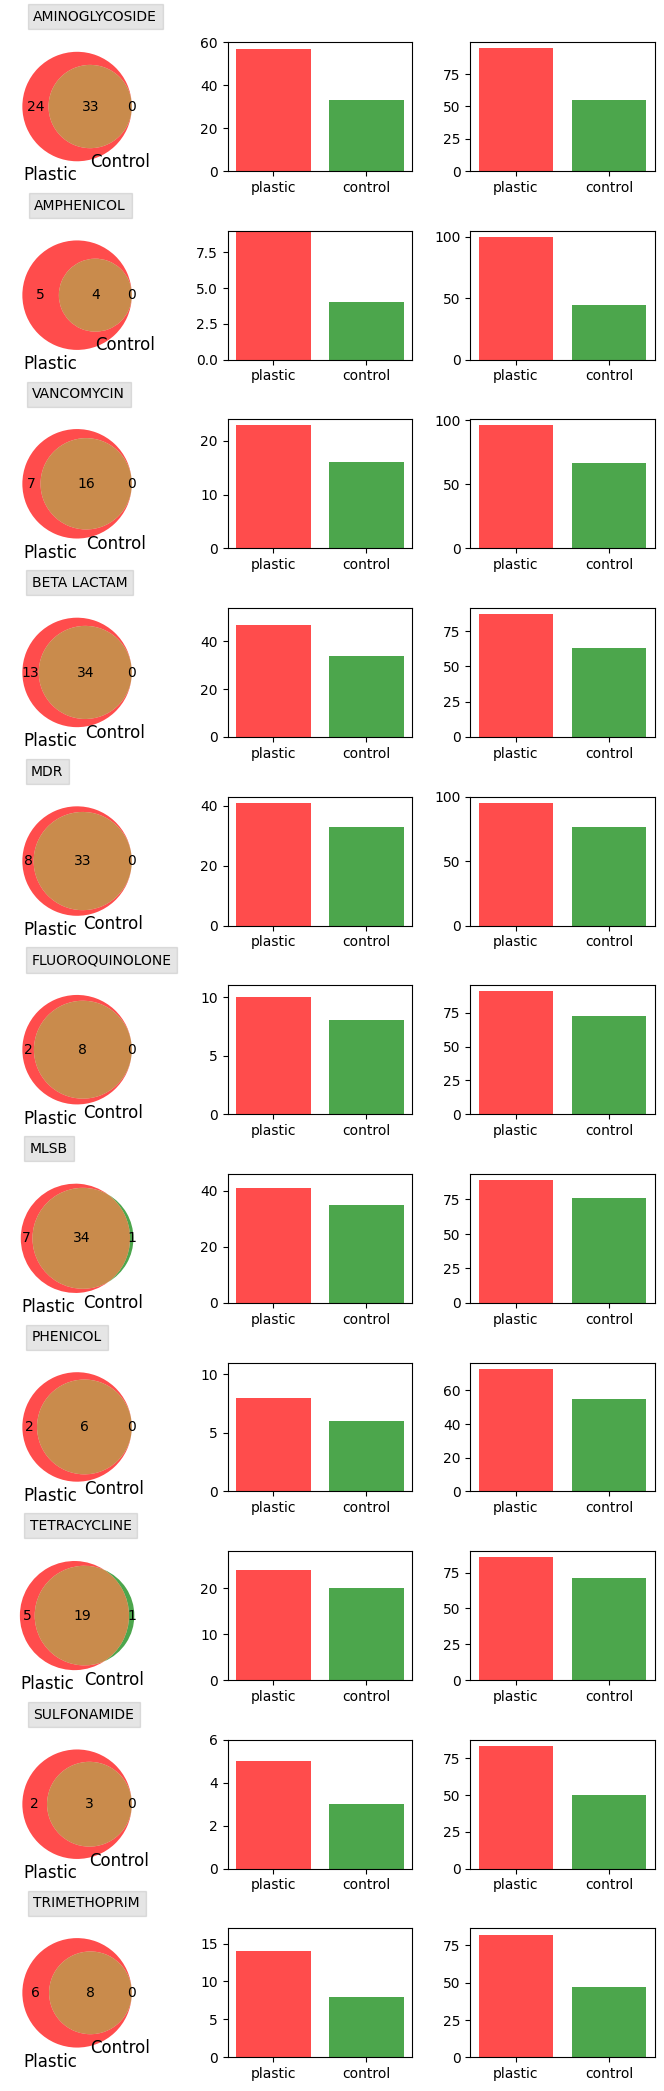

In [12]:
fig = plt.figure(figsize = (7, (len(arg_data.index)*2) - 1))

left = -0.5
x_axis = ["plastic", "control"]
pos = 1

for cat in list(arg_data.index):
    #diagrama de venn
    ax = fig.add_subplot(len(arg_data.index), 3, pos)
    venn2(subsets= ((arg_data.loc[cat]["plastic_reps"]), 
                    (arg_data.loc[cat]["control_reps"]),
                    (arg_data.loc[cat]["both_reps"])),
          set_labels=("Plastic", "Control"), 
          set_colors=("red", "green"), alpha=0.7)
    top = ax.get_ylim()[1] * 1.5
    txt = ax.text(left, top, s = cat.upper(), verticalalignment='top')
    txt.set_bbox(dict(facecolor='k', alpha=0.1))
    
    pos += 1 #mueve en la figura una posición
    
    #barplot de total
    ax = fig.add_subplot(len(arg_data.index), 3, pos)
    ax.bar(x = x_axis, 
           height = [(arg_data.loc[cat]["plastic_reps"] + arg_data.loc[cat]["both_reps"]),
                     (arg_data.loc[cat]["control_reps"] +  arg_data.loc[cat]["both_reps"])],
                     color = ["red", "green"], 
                     alpha = 0.7
                    )
    ax.set_ylim(top = arg_data.loc[cat]["total_reps"])
    
    pos += 1
    
    #barplot de %
    ax = fig.add_subplot(len(arg_data.index), 3, pos)
    ax.bar(x = x_axis, 
           height = [(((arg_data.loc[cat]["plastic_reps"] + arg_data.loc[cat]["both_reps"])*100)/ arg_data.loc[cat]["total_reps"]), 
                     (((arg_data.loc[cat]["control_reps"] + arg_data.loc[cat]["both_reps"]) * 100) / arg_data.loc[cat]["total_reps"])
                    ],
           color = ["red", "green"], alpha = 0.7
          )
    
    pos += 1

fig.tight_layout()
plt.show()

### COMPARATIVA DEL Nº DE DETECCIONES A NIVEL DE MGE

In [13]:
mge_data

,total_reps,control_reps,plastic_reps,both_reps,or_seq
Other,12,0,2,10,mge
Insertional,9,0,2,7,mge
Integrase,4,0,1,3,mge
MGE,24,0,7,14,mge
Plasmid,3,0,0,3,mge
Plasmid-inc,5,0,1,4,mge
Plasmid-rep,3,0,0,0,mge
Transposase,10,0,4,6,mge


Nuevamente, hay MGE que no llegaron a detectarse en ningún caso

In [14]:
mge_clean = mge_data.loc[(mge_data["control_reps"] != 0 )| (mge_data["plastic_reps"] != 0) | (mge_data["both_reps"] != 0)]
not_detected = set(mge_data.index) - set (mge_clean.index)

mge_data = mge_clean
print("The following MGE categories: \n", not_detected, "\n were not detected")

The following MGE categories: 
 {'Plasmid-rep'} 
 were not detected


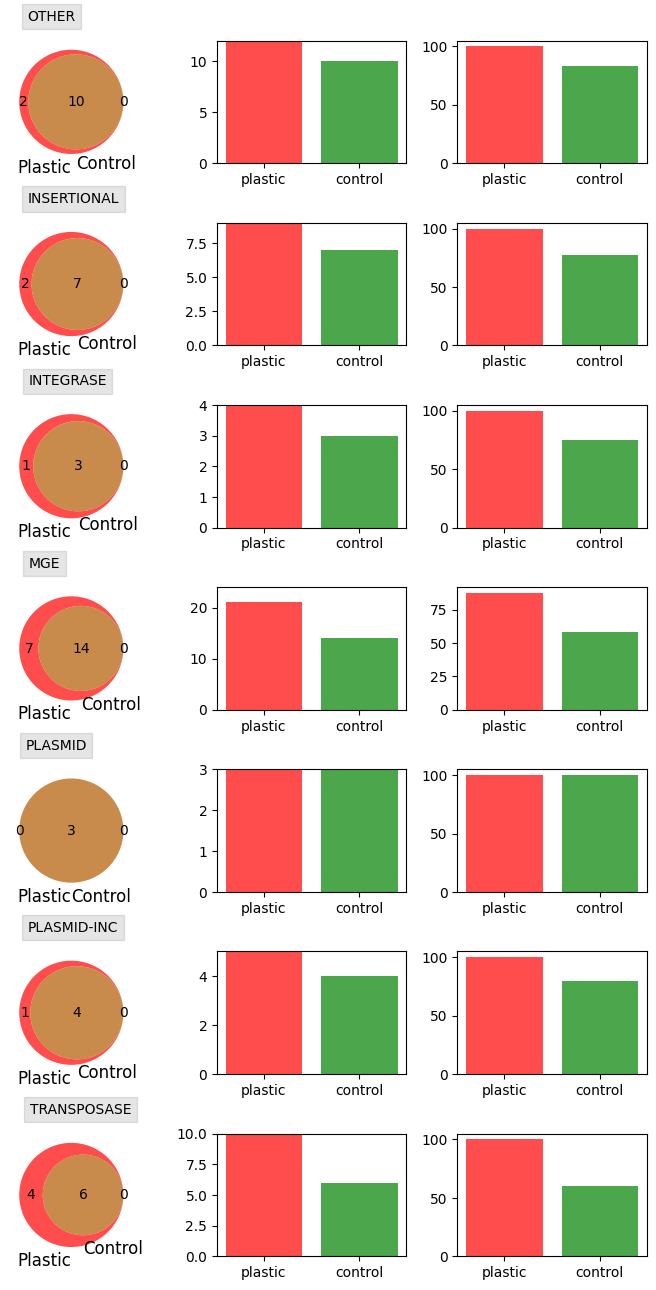

In [16]:
fig = plt.figure(figsize = (7, (len(mge_data.index)*2) - 1))

left = -0.5
x_axis = ["plastic", "control"]
pos = 1

for cat in list(mge_data.index):
    #diagrama de venn
    ax = fig.add_subplot(len(mge_data.index), 3, pos)
    venn2(subsets= ((mge_data.loc[cat]["plastic_reps"]), 
                    (mge_data.loc[cat]["control_reps"]),
                    (mge_data.loc[cat]["both_reps"])),
          set_labels=("Plastic", "Control"), 
          set_colors=("red", "green"), alpha=0.7)
    top = ax.get_ylim()[1] * 1.5
    txt = ax.text(left, top, s = cat.upper(), verticalalignment='top')
    txt.set_bbox(dict(facecolor='k', alpha=0.1))
    
    pos += 1 #mueve en la figura una posición
    
    #barplot de total
    ax = fig.add_subplot(len(mge_data.index), 3, pos)
    ax.bar(x = x_axis, 
           height = [(mge_data.loc[cat]["plastic_reps"] + mge_data.loc[cat]["both_reps"]), 
                     (mge_data.loc[cat]["control_reps"] + mge_data.loc[cat]["both_reps"])],
           color = ["red", "green"], alpha = 0.7
          )
    ax.set_ylim(top = mge_data.loc[cat]["total_reps"])
    
    pos += 1
    
    #barplot de %
    ax = fig.add_subplot(len(mge_data.index), 3, pos)
    ax.bar(x = x_axis, 
           height = [(((mge_data.loc[cat]["plastic_reps"] + mge_data.loc[cat]["both_reps"])*100)/ mge_data.loc[cat]["total_reps"]), 
                     (((mge_data.loc[cat]["control_reps"] + mge_data.loc[cat]["both_reps"]) * 100) / mge_data.loc[cat]["total_reps"])
                    ],
           color = ["red", "green"], alpha = 0.7
          )
    
    pos += 1

fig.tight_layout()
plt.show()

## ANÁLISIS ESTADÍSTICOS

Debiera ser posible llevar a cabo análisis estadísticos de diferencias en el nº de positivos si hiciéramos algo que en el caso de la comparación del nº de copia hemos evitado: usar la información de las amplificaciones fallidas.

Me explico: a nivel de gen individual tenemos tan solo el valor de Ct, pero tenemos cada gen individual por dieciochiplicado (* 18), correspondiéndose cada una de esas 18 réplicas con una condición distinta (lago/tipo plástico/etc). Tan solo 21 (ARG y MGE) de las 382 secuencias testeadas eran compartidas, y al decidir no considerar las amplificaciones fallidas por sus peculiaridades, no podíamos comparar entre sí por el bajo n (**cabe mencionar que si el Ct se transforma a nº de copia se evita el problema que suponen los 0s**)

Ahora bien, **si SÍ que contabilizamos las amplificaciones fallidas, cada amplificación individual (sí amplifica/ no) se puede convertir en varios datos y ganar así la posibilidad de trabajar estadísticamente con ellos estudiando los datos agrupados**

Por ejemplo, hay **8 réplicas de control** frente a **10 réplicas de plástico**. Un gen individual con 2 amplificaciones en el control y 6 en el plástico habrá amplificado en un 25% de los controles y 60% de los plásticos. **Si ese gen forma parte de una familia con 26 otros genes, podemos obtener información sobre si en una familia el % de detección sobre el total de muestras es significativamente distinto en plásticos que en controles, pues podemos calcular su media, varianza, etc.**

In [17]:
# Va a ser inmenso, asi que meto un to_csv para poder inspeccionarlo después
rep_info = {} 
for seq in amp_data["Assay"].unique():
    seq_data = amp_data[(amp_data["Assay"] == seq)]
    control_seqs = set(seq_data.loc[(seq_data["type_g"] == "control")]["Assay"])
    plastic_seqs = set(seq_data.loc[(seq_data["type_g"] == "plastic")]["Assay"])
    control_reps = len(control_seqs - plastic_seqs)
    plastic_reps = len(plastic_seqs - control_seqs)
    plastic_reps = len(plastic_seqs - control_seqs)
    both_reps = 0
    grouped_seqs = seq_data.groupby("Assay")
    for name, group in grouped_seqs:
        if len(group["type_g"].unique()) == 2: both_reps += 1
    
    
    type_seq = list(seq_data["or_seq"].unique())
    type_seq = "".join(type_seq)
    type_fam = list(seq_data["antib"].unique())
    type_fam = "".join(type_fam)
    rep_info[seq] = (control_reps, plastic_reps, both_reps, type_seq, type_fam)

seq_reps_df = pd.DataFrame.from_dict(rep_info, orient = "index", 
                                     columns = ["control_reps", "plastic_reps","both_reps", "type_seq", "type_fam"])

del rep_info
del plastic_reps
del control_reps
del seq_data
del seq

#seq_reps_df.to_csv("tratratratra")
#seq_reps_df.drop("16S", inplace = True)
seq_reps_df

,control_reps,plastic_reps,both_reps,type_seq,type_fam
aacC2,0,0,1,arg,Aminoglycoside
aacA/aphD,0,1,0,arg,Aminoglycoside
aac(6')-II,0,1,0,arg,Aminoglycoside
aphA3,0,1,0,arg,Aminoglycoside
sat4,0,0,0,arg,Aminoglycoside
...,...,...,...,...,...
dfrAB4,0,0,1,arg,Trimethoprim
dfrC,0,1,0,arg,Trimethoprim
dfrG,0,0,1,arg,Trimethoprim
dfrK,0,0,1,arg,Trimethoprim


Como detalle final, el nº de filas del df en el que se detalla la información de cada secuencia individual (=382) coincide con el nº de secuencias total que se obtiene en el df generalizado (310 ARG + 72 MGE). Eso nos indica que los df generados son correctos.

Voy a probar a sacar los estadísticos de los ARG

In [18]:
#dato gracioso: esto nos debiera dar, de rebote, el mismo df que he hecho en family_reps pero más completo
stat_test = seq_reps_df.groupby("type_fam").describe()
stat_test.tail()

control_reps                                               \
                    count      mean       std  min  25%  50%  75%  max   
type_fam                                                                 
Sulfonamide           6.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
Tetracycline         28.0  0.035714  0.188982  0.0  0.0  0.0  0.0  1.0   
Transposase          10.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
Trimethoprim         17.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
Vancomycin           24.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   

             plastic_reps            ...            both_reps            \
                    count      mean  ...   75%  max     count      mean   
type_fam                             ...                                  
Sulfonamide           6.0  0.333333  ...  0.75  1.0       6.0  0.500000   
Tetracycline         28.0  0.178571  ...  0.00  1.0      28.0  0.678571   
Transposase          10.0  0.400000  ...  1.00  1.0      10.0  0.600000   
Trimethoprim         17.0  0.352941  ...  1.00  1.0      17.0  0.470588   
Vancomycin           24.0  0.291667  ...  1.00  1.0      24.0  0.666667   

                                                 
                   std  min  25%  50%  75%  max  
type_fam                                         
Sulfonamide   0.547723  0.0  0.0  0.5  1.0  1.0  
Tetracycline  0.475595  0.0  0.0  1.0  1.0  1.0  
Transposase   0.516398  0.0  0.0  1.0  1.0  1.0  
Trimethoprim  0.514496  0.0  0.0  0.0  1.0  1.0  
Vancomycin    0.481543  0.0  0.0  1.0  1.0  1.0  

[5 rows x 24 columns]

Como se puede comprobar con el caso de la tetraciclina, sacar los estadísticos tal cual no sirve de nada, pues no es la media de amplificaciones per se lo que necesitamos, es un dato falso: está tomando el nº de amplificaciones positivas que haya tenido el gen anti tetraciclina (uno solo de 28, ver family_reps) y calculando la media de su valor con 27 0's.

Detallado: sólo amplifica en las muestras control el gen tetPA, y lo hace en 2 muestras. Calcular la media tal cual conlleva que se toma ese valor, se suma a 0 * 27, y se divide entre el total de muestras (28) = 0,071.

Sin embargo, tal y como lo hemos planteado, ese 2 en realidad no es 2, sino 2 amplificaciones positivas sobre 8 réplicas de control = 25%. Asi que la media es (25 + 0 * 27) / 28 = 0,893%

Por tanto, lo que está fallando es no convertir los valores de amplificación a % sobre el total de muestras en cuestión. Procedo a ello.

In [19]:
del stat_test

In [20]:
seq_reps_df["control_pct"] = ((seq_reps_df["control_reps"] + seq_reps_df["both_reps"])*100) / 8
seq_reps_df["plastic_pct"] = ((seq_reps_df["plastic_reps"] + seq_reps_df["both_reps"])*100) / 10
seq_reps_df.head()

,control_reps,plastic_reps,both_reps,type_seq,type_fam,control_pct,plastic_pct
aacC2,0,0,1,arg,Aminoglycoside,12.5,10.0
aacA/aphD,0,1,0,arg,Aminoglycoside,0.0,10.0
aac(6')-II,0,1,0,arg,Aminoglycoside,0.0,10.0
aphA3,0,1,0,arg,Aminoglycoside,0.0,10.0
sat4,0,0,0,arg,Aminoglycoside,0.0,0.0


In [21]:
test = seq_reps_df[["plastic_pct", "control_pct", "type_fam"]]
stat_test = test.groupby("type_fam").describe()
stat_test

plastic_pct                                               \
                      count       mean       std   min   25%   50%   75%   
type_fam                                                                   
Aminoglycoside         60.0   9.500000  2.197842   0.0  10.0  10.0  10.0   
Amphenicol              9.0  10.000000  0.000000  10.0  10.0  10.0  10.0   
Beta Lactam            54.0   8.703704  3.390495   0.0  10.0  10.0  10.0   
Fluoroquinolone        11.0   9.090909  3.015113   0.0  10.0  10.0  10.0   
Insertional             9.0  10.000000  0.000000  10.0  10.0  10.0  10.0   
Integrase               4.0  10.000000  0.000000  10.0  10.0  10.0  10.0   
MDR                    43.0   9.534884  2.130826   0.0  10.0  10.0  10.0   
MGE                    24.0   8.750000  3.378320   0.0  10.0  10.0  10.0   
MLSB                   46.0   8.913043  3.146964   0.0  10.0  10.0  10.0   
Other                  12.0  10.000000  0.000000  10.0  10.0  10.0  10.0   
Phenicol               11.0   7.272727  4.670994   0.0   5.0  10.0  10.0   
Plasmid                 3.0  10.000000  0.000000  10.0  10.0  10.0  10.0   
Plasmid-inc             5.0  10.000000  0.000000  10.0  10.0  10.0  10.0   
Plasmid-rep             3.0   0.000000  0.000000   0.0   0.0   0.0   0.0   
Sulfonamide             6.0   8.333333  4.082483   0.0  10.0  10.0  10.0   
Tetracycline           28.0   8.571429  3.563483   0.0  10.0  10.0  10.0   
Transposase            10.0  10.000000  0.000000  10.0  10.0  10.0  10.0   
Trimethoprim           17.0   8.235294  3.929526   0.0  10.0  10.0  10.0   
Vancomycin             24.0   9.583333  2.041241   0.0  10.0  10.0  10.0   

                      control_pct                                            \
                  max       count       mean       std   min     25%    50%   
type_fam                                                                      
Aminoglycoside   10.0        60.0   6.875000  6.271151   0.0   0.000  12.50   
Amphenicol       10.0         9.0   5.555556  6.588078   0.0   0.000   0.00   
Beta Lactam      10.0        54.0   7.870370  6.092979   0.0   0.000  12.50   
Fluoroquinolone  10.0        11.0   9.090909  5.838742   0.0   6.250  12.50   
Insertional      10.0         9.0   9.722222  5.511982   0.0  12.500  12.50   
Integrase        10.0         4.0   9.375000  6.250000   0.0   9.375  12.50   
MDR              10.0        43.0   9.593023  5.343282   0.0  12.500  12.50   
MGE              10.0        24.0   7.291667  6.295127   0.0   0.000  12.50   
MLSB             10.0        46.0   9.510870  5.390825   0.0  12.500  12.50   
Other            10.0        12.0  10.416667  4.865618   0.0  12.500  12.50   
Phenicol         10.0        11.0   6.818182  6.527912   0.0   0.000  12.50   
Plasmid          10.0         3.0  12.500000  0.000000  12.5  12.500  12.50   
Plasmid-inc      10.0         5.0  10.000000  5.590170   0.0  12.500  12.50   
Plasmid-rep       0.0         3.0   0.000000  0.000000   0.0   0.000   0.00   
Sulfonamide      10.0         6.0   6.250000  6.846532   0.0   0.000   6.25   
Tetracycline     10.0        28.0   8.928571  5.750546   0.0   0.000  12.50   
Transposase      10.0        10.0   7.500000  6.454972   0.0   0.000  12.50   
Trimethoprim     10.0        17.0   5.882353  6.431197   0.0   0.000   0.00   
Vancomycin       10.0        24.0   8.333333  6.019293   0.0   0.000  12.50   

                             
                  75%   max  
type_fam                     
Aminoglycoside   12.5  12.5  
Amphenicol       12.5  12.5  
Beta Lactam      12.5  12.5  
Fluoroquinolone  12.5  12.5  
Insertional      12.5  12.5  
Integrase        12.5  12.5  
MDR              12.5  12.5  
MGE              12.5  12.5  
MLSB             12.5  12.5  
Other            12.5  12.5  
Phenicol         12.5  12.5  
Plasmid          12.5  12.5  
Plasmid-inc      12.5  12.5  
Plasmid-rep       0.0   0.0  
Sulfonamide      12.5  12.5  
Tetracycline     12.5  12.5  
Transposase      12.5  12.5  
Trim

Y lo mismo, pero a nivel más general

In [22]:
test = seq_reps_df[["plastic_pct", "control_pct", "type_seq"]]
stat_test = test.groupby("type_seq").describe()
stat_test

plastic_pct                                                  \
               count      mean      std  min   25%   50%   75%   max   
type_seq                                                               
arg            309.0  9.029126  2.96557  0.0  10.0  10.0  10.0  10.0   
mge             70.0  9.142857  2.81963  0.0  10.0  10.0  10.0  10.0   

         control_pct                                                  
               count      mean       std  min  25%   50%   75%   max  
type_seq                                                              
arg            309.0  8.090615  5.982513  0.0  0.0  12.5  12.5  12.5  
mge             70.0  8.392857  5.913564  0.0  0.0  12.5  12.5  12.5

In [23]:
del stat_test
del test

Apunte rápido: las medias son extraordinariamente bajas porque, como hemos visto, se amplifican en el mejor de los casos el 15%/20% de los genes presentes, de manera que la gran mayoría de los valores con los que se computan las medias son 0%. Ahora bien, esto no tiene solución: si eliminara las secuencias no amplificadas de la ecuación cambiaría la naturaleza de los valores obtenidos, pues dejarían de ser un "se detecta ARG de media en un 4,9% de las muestras, estadísticamente 4 veces más que en el medio circundante" a un "los ARG detectados de media están presentes en un 40% de las muestras de plástico vs un 10% de las muestras de control", dato que, a mi parecer, no tiene apenas valor ecosistémico/biológico.

Ahora bien, eso no significa que no podamos simplificar el análisis de dos maneras muy sencillas, pues a) lo único que podemos decir de aquellas muestras no detectadas en ningún caso es que no han sido detectadas en ningún caso (y deducir que no están presentes en el medio) y b) las muestras sólo detectadas en plástico (no se da el caso contrario) no tenemos porqué analizarlas porque son inifinitamente distintas a las muestras de control (**y son, no olvidemos, uno de los resultados más significativos e importantes**)

**Ahora bien, estos dos filtros sólo aplican a estudios a nivel de familia. Para estudios a nivel general, debemos conservar todas las secuencias por los puntos antes expuestos**

## COMPARATIVA DEL % DE DETECCIONES EN LAS MUESTRAS A NIVEL DE FAMILIA

In [24]:
# Vamos a simplificar el dataset para trabajar con familias. 
# Dejo el original intacto para conclusiones a nivel general
seq_clean = seq_reps_df.groupby("type_fam")

not_detected = []
plas_exclusive_fams = []
control_exclusive_fams = []

for name, group in seq_clean:
    #print(name)
    #print(group.columns)
    if (group["control_reps"].sum() == 0) and (group["plastic_reps"].sum() == 0) and (group["both_reps"].sum() == 0): #familias no detectadas en nigún caso
        ugly_hack = list(group["type_fam"].unique())
        ugly_hack = "".join(ugly_hack)
        not_detected.append(ugly_hack)
    elif (group["plastic_reps"].sum() > 0) and (group["both_reps"].sum() == 0): #familias EXCLUSIVAS DE PLAS
        ugly_hack = list(group["type_fam"].unique())
        ugly_hack = "".join(ugly_hack)
        plas_exclusive_fams.append(ugly_hack)
    elif (group["control_reps"].sum() > 0) and (group["both_reps"].sum() == 0): #familias EXCLUSIVAS DE CONT
        ugly_hack = list(group["type_fam"].unique())
        ugly_hack = "".join(ugly_hack)
        control_exclusive_fams.append(ugly_hack)

print("The following families were not detected:")
print(not_detected)
print("")
print("The following families are EXCLUSIVE TO PLASTIC:")
print(plas_exclusive_fams)
print("")
print("The following families are EXCLUSIVE TO CONTROL:")
print(control_exclusive_fams)

seq_clean = seq_reps_df[~(seq_reps_df["type_fam"].isin(not_detected))] #ojo aquí, reutilizo el nombre de la variable
seq_clean = seq_clean[~(seq_clean["type_fam"].isin(control_exclusive_fams))]
seq_clean = seq_clean[~(seq_clean["type_fam"].isin(plas_exclusive_fams))]

seq_clean

The following families were not detected:
['Plasmid-rep']

The following families are EXCLUSIVE TO PLASTIC:
[]

The following families are EXCLUSIVE TO CONTROL:
[]


,control_reps,plastic_reps,both_reps,type_seq,type_fam,control_pct,plastic_pct
aacC2,0,0,1,arg,Aminoglycoside,12.5,10.0
aacA/aphD,0,1,0,arg,Aminoglycoside,0.0,10.0
aac(6')-II,0,1,0,arg,Aminoglycoside,0.0,10.0
aphA3,0,1,0,arg,Aminoglycoside,0.0,10.0
sat4,0,0,0,arg,Aminoglycoside,0.0,0.0
...,...,...,...,...,...,...,...
dfrAB4,0,0,1,arg,Trimethoprim,12.5,10.0
dfrC,0,1,0,arg,Trimethoprim,0.0,10.0
dfrG,0,0,1,arg,Trimethoprim,12.5,10.0
dfrK,0,0,1,arg,Trimethoprim,12.5,10.0


In [25]:
def statistic_mean(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)

In [26]:
print ("Unless told otherwise, assume the worst \n")
test = seq_clean.groupby("type_fam")
for name, group in test:
    normality_plas = stats.shapiro(x = group["plastic_pct"])[1] 
    normality_control = stats.shapiro(x = group["control_pct"])[1]
    normality = normality_control + normality_plas #para simplificar
    if normality >= 0.1: #ambos > 0.05 para satisfacer esta condición
        norm = True
        #print("Both normal")
        homocedasticity = stats.levene(group["plastic_pct"], group["control_pct"], center = "mean")[1]
    else: 
        norm = False
        homocedasticity = stats.levene(group["plastic_pct"], group["control_pct"], center = "median")[1]
    if (homocedasticity >= 0.05) and (norm == True): 
        result = stats.ttest_ind(a = group["plastic_pct"], b = group["control_pct"],
                                 equal_var = True, alternative = "greater")
    
    elif (homocedasticity > 0.05): #homocedásticos no normales
        result = stats.mannwhitneyu(x = group["plastic_pct"], y = group["control_pct"], alternative = "greater")
    
    elif (homocedasticity < 0.05) and (norm == True):
        result = stats.ttest_ind(a = group["plastic_pct"], b = group["control_pct"], alternative = "greater", equal_var = False)
        result = ("Welch!", result[1], result[0])
    else: #todo mal, permuta
        result = stats.permutation_test(data = (group["plastic_pct"], group["control_pct"]), statistic =  statistic_mean, 
                                        vectorized = True, n_resamples = 20000,
                                        alternative = "greater", permutation_type = "independent")
        result = ("Permutation", result.pvalue, result.statistic) #ugly hack!
    if result[1] < 0.05:
        print("############", name, "############")
        print(result)
        print("")

Unless told otherwise, assume the worst 

############ Aminoglycoside ############
('Permutation', 0.0014499275036248187, 2.625)

############ Amphenicol ############
('Welch!', 0.038796503472097, 2.023857702507763)



In [27]:
control_vals = [group["control_pct"] for name, group in seq_clean.groupby(["type_seq", "type_fam"])]# they are separated so I have to zip them
plastic_vals = [group["plastic_pct"] for name, group in seq_clean.groupby(["type_seq", "type_fam"])]
nam_control = [list(name) + ["control"] for name, group in seq_clean.groupby(["type_seq", "type_fam"])]
nam_plastic = [list(name) + ["plastic"] for name, group in seq_clean.groupby(["type_seq", "type_fam"])]
values_both = list(zip(control_vals, plastic_vals))
names_both = list(zip(nam_control, nam_plastic))
values_both = [value for val_lst in values_both for value in val_lst]
names_both = [tuple(name) for nam_lst in names_both for name in nam_lst] #caótico pero funciona que flipas
#names_both

In [28]:
print("Regular values: ", stats.levene(*values_both))
print(stats.kruskal(*values_both))
post_lolo = sp.posthoc_conover(values_both, p_adjust = "holm")

post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, names_both)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, names_both)},
                 inplace = True)

# Y ahora ver solo lo interesante
post_lolo = post_lolo[post_lolo < 0.05]
#esto enfrenta a control (filas) vs plástico (columnas)
post_lolo_control = post_lolo.iloc[0:post_lolo.shape[0]:2,1:(post_lolo.shape[1]+1):2]
#y esto saca sólo la diagonal
post_lolo_diag = pd.Series(np.diag(post_lolo_control), index=[post_lolo_control.index, post_lolo_control.columns])
post_lolo_diag

Regular values:  LeveneResult(statistic=3.794705049560166, pvalue=5.645330441862276e-12)
KruskalResult(statistic=111.72925835898462, pvalue=6.041327762563936e-10)


(arg, Aminoglycoside, control)   (arg, Aminoglycoside, plastic)          NaN
(arg, Amphenicol, control)       (arg, Amphenicol, plastic)              NaN
(arg, Beta Lactam, control)      (arg, Beta Lactam, plastic)             NaN
(arg, Fluoroquinolone, control)  (arg, Fluoroquinolone, plastic)         NaN
(arg, MDR, control)              (arg, MDR, plastic)                0.008818
(arg, MLSB, control)             (arg, MLSB, plastic)               0.001067
(arg, Phenicol, control)         (arg, Phenicol, plastic)                NaN
(arg, Sulfonamide, control)      (arg, Sulfonamide, plastic)             NaN
(arg, Tetracycline, control)     (arg, Tetracycline, plastic)            NaN
(arg, Trimethoprim, control)     (arg, Trimethoprim, plastic)            NaN
(arg, Vancomycin, control)       (arg, Vancomycin, plastic)              NaN
(mge, Insertional, control)      (mge, Insertional, plastic)             NaN
(mge, Integrase, control)        (mge, Integrase, plastic)               NaN

Misma historia, pero en esta ocasión separando ARG y MGE

In [29]:
arg_data = seq_clean.loc[seq_clean["type_seq"] == "arg"]
mge_data = seq_clean.loc[seq_clean["type_seq"] == "mge"]

control_vals_arg = [group["control_pct"] for name, group in arg_data.groupby(["type_seq", "type_fam"])]# they are separated so I have to zip them
plastic_vals_arg = [group["plastic_pct"] for name, group in arg_data.groupby(["type_seq", "type_fam"])]
nam_control_arg = [list(name) + ["control"] for name, group in arg_data.groupby(["type_seq", "type_fam"])]
nam_plastic_arg = [list(name) + ["plastic"] for name, group in arg_data.groupby(["type_seq", "type_fam"])]
values_both_arg = list(zip(control_vals_arg, plastic_vals_arg))
names_both_arg = list(zip(nam_control_arg, nam_plastic_arg))
values_both_arg = [value for val_lst in values_both_arg for value in val_lst]
names_both_arg = [tuple(name) for nam_lst in names_both_arg for name in nam_lst]

control_vals_mge = [group["control_pct"] for name, group in mge_data.groupby(["type_seq", "type_fam"])]# they are separated so I have to zip them
plastic_vals_mge = [group["plastic_pct"] for name, group in mge_data.groupby(["type_seq", "type_fam"])]
nam_control_mge = [list(name) + ["control"] for name, group in mge_data.groupby(["type_seq", "type_fam"])]
nam_plastic_mge = [list(name) + ["plastic"] for name, group in mge_data.groupby(["type_seq", "type_fam"])]
values_both_mge = list(zip(control_vals_mge, plastic_vals_mge))
names_both_mge = list(zip(nam_control_mge, nam_plastic_mge))
values_both_mge = [value for val_lst in values_both_mge for value in val_lst]
names_both_mge = [tuple(name) for nam_lst in names_both_mge for name in nam_lst]

In [30]:
print("Regular values: ", stats.levene(*values_both_arg))
print(stats.kruskal(*values_both_arg))
post_lolo = sp.posthoc_conover(values_both_arg, p_adjust = "holm")

post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, names_both_arg)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, names_both_arg)},
                 inplace = True)

# Y ahora ver solo lo interesante
post_lolo = post_lolo[post_lolo < 0.05]
#esto enfrenta a control (filas) vs plástico (columnas)
post_lolo_control = post_lolo.iloc[0:post_lolo.shape[0]:2,1:(post_lolo.shape[1]+1):2]
#y esto saca sólo la diagonal
post_lolo_diag = pd.Series(np.diag(post_lolo_control), index=[post_lolo_control.index, post_lolo_control.columns])
post_lolo_diag

Regular values:  LeveneResult(statistic=4.925400393916153, pvalue=1.0264855186975196e-11)
KruskalResult(statistic=82.59174815852174, pvalue=2.964637768702179e-09)


(arg, Aminoglycoside, control)   (arg, Aminoglycoside, plastic)          NaN
(arg, Amphenicol, control)       (arg, Amphenicol, plastic)              NaN
(arg, Beta Lactam, control)      (arg, Beta Lactam, plastic)             NaN
(arg, Fluoroquinolone, control)  (arg, Fluoroquinolone, plastic)         NaN
(arg, MDR, control)              (arg, MDR, plastic)                0.004876
(arg, MLSB, control)             (arg, MLSB, plastic)               0.000632
(arg, Phenicol, control)         (arg, Phenicol, plastic)                NaN
(arg, Sulfonamide, control)      (arg, Sulfonamide, plastic)             NaN
(arg, Tetracycline, control)     (arg, Tetracycline, plastic)            NaN
(arg, Trimethoprim, control)     (arg, Trimethoprim, plastic)            NaN
(arg, Vancomycin, control)       (arg, Vancomycin, plastic)              NaN
dtype: float64

In [31]:
print("Regular values: ", stats.levene(*values_both_mge))
print(stats.kruskal(*values_both_mge))
post_lolo = sp.posthoc_conover(values_both_mge, p_adjust = "holm")

post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, names_both_mge)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, names_both_mge)},
                 inplace = True)

# Y ahora ver solo lo interesante
post_lolo = post_lolo[post_lolo < 0.05]
#esto enfrenta a control (filas) vs plástico (columnas)
post_lolo_control = post_lolo.iloc[0:post_lolo.shape[0]:2,1:(post_lolo.shape[1]+1):2]
#y esto saca sólo la diagonal
post_lolo_diag = pd.Series(np.diag(post_lolo_control), index=[post_lolo_control.index, post_lolo_control.columns])
post_lolo_diag

Regular values:  LeveneResult(statistic=2.193657456949079, pvalue=0.013562763469680822)
KruskalResult(statistic=28.774773998135988, pvalue=0.0070446592553223015)


(mge, Insertional, control)  (mge, Insertional, plastic)   NaN
(mge, Integrase, control)    (mge, Integrase, plastic)     NaN
(mge, MGE, control)          (mge, MGE, plastic)           NaN
(mge, Other, control)        (mge, Other, plastic)         NaN
(mge, Plasmid, control)      (mge, Plasmid, plastic)       NaN
(mge, Plasmid-inc, control)  (mge, Plasmid-inc, plastic)   NaN
(mge, Transposase, control)  (mge, Transposase, plastic)   NaN
dtype: float64

In [32]:
test = seq_clean[["control_pct", "type_fam", "type_seq"]]
#print(test.shape[0])
test.rename(columns = {"control_pct": "pct"}, inplace = True)
test["type_g"] = "control" 
test2 = seq_clean[["plastic_pct", "type_fam", "type_seq"]]
#print(test2.shape[0])
test2.rename(columns = {"plastic_pct": "pct"}, inplace = True)
test2["type_g"] = "plastic"
test = pd.merge(test, test2, how = "outer")
#print(test.shape[0])
del test2
test

,pct,type_fam,type_seq,type_g
0,12.5,Aminoglycoside,arg,control
1,12.5,Aminoglycoside,arg,control
2,12.5,Aminoglycoside,arg,control
3,12.5,Aminoglycoside,arg,control
4,12.5,Aminoglycoside,arg,control
...,...,...,...,...
747,10.0,Trimethoprim,arg,plastic
748,10.0,Trimethoprim,arg,plastic
749,0.0,Trimethoprim,arg,plastic
750,0.0,Trimethoprim,arg,plastic


<Figure size 1000x600 with 0 Axes>

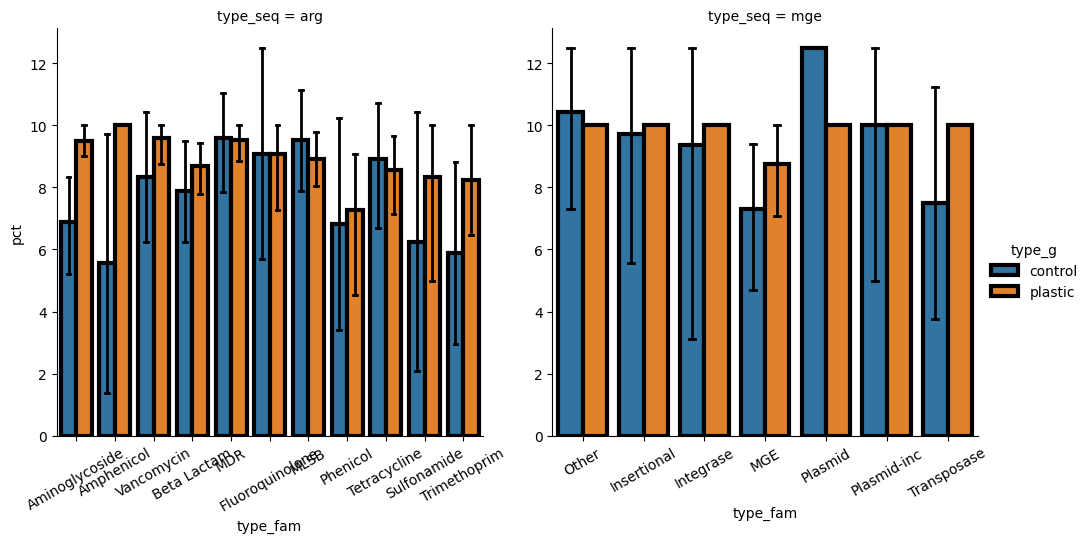

In [33]:
plt.figure(figsize=(10,6))
lala = sns.catplot(data=test, 
                   x="type_fam", y="pct", 
                   col="type_seq", hue = "type_g",
                   kind = "bar", 
                   sharey = False, sharex = False,
                   errorbar=("ci", 95), capsize=.1, errcolor="black", errwidth = 2,
                   linewidth=3, edgecolor="black")
lala.set_xticklabels(rotation=30);

## COMPARATIVA DEL % DE DETECCIONES POR MUESTRA EN GENERAL

Misma idea, pero esta vez sin diferenciar por familias, sólo plástico vs control

In [34]:
print ("Unless told otherwise, assume the worst \n")
test = seq_reps_df.groupby("type_seq")
for name, group in test:
    print("############", name, "############")
    normality_plas = stats.shapiro(x = group["plastic_pct"])[1] 
    normality_control = stats.shapiro(x = group["control_pct"])[1]
    normality = normality_control + normality_plas #para simplificar
    if normality >= 0.1: #ambos > 0.05 para satisfacer esta condición
        print("Both normal")
        homocedasticity = stats.levene(group["plastic_pct"], group["control_pct"], center = "mean")[1]
    else: 
        homocedasticity = stats.levene(group["plastic_pct"], group["control_pct"], center = "median")[1]
    if homocedasticity > 0.05: print("Homocedastic")
    else:
        if normality >= 0.1: print(stats.ttest_ind(a = group["plastic_pct"],
                                                   b = group["control_pct"],
                                                   equal_var = False,
                                                   alternative = "greater") #ojo, Ha = a > b
                                  )
    if (normality >= 0.1) and (homocedasticity >= 0.05):
        print(stats.ttest_ind(a = group["plastic_pct"],
                              b = group["control_pct"],
                              equal_var = True,
                              alternative = "greater") #ojo
             )
    elif (normality < 0.1) and (homocedasticity > 0.05):
        print(stats.mannwhitneyu(x = group["plastic_pct"],
                                 y = group["control_pct"],
                                 alternative = "greater") # ojo
             )
    else:
        print(stats.permutation_test(data = (group["plastic_pct"], group["control_pct"]), statistic =  statistic_mean,
                                     vectorized = True, n_resamples = 20000,
                                     alternative = "greater", permutation_type = "independent") #ojo
             ) 
             
    print("")

Unless told otherwise, assume the worst 

############ arg ############
PermutationTestResult(statistic=0.9385113268608425, pvalue=0.0087995600219989, null_distribution=array([-0.61488673,  0.08090615,  0.01618123, ..., -0.22653722,
       -0.06472492,  0.64724919]))

############ mge ############
PermutationTestResult(statistic=0.75, pvalue=0.18019099045047748, null_distribution=array([ 0.10714286,  1.03571429,  0.67857143, ..., -0.17857143,
       -0.10714286,  0.96428571]))



In [35]:
test = seq_clean[["control_pct", "type_seq"]]
print(test.shape[0])
test.rename(columns = {"control_pct": "pct"}, inplace = True)
test["type_g"] = "control" 
test2 = seq_clean[["plastic_pct", "type_seq"]]
print(test2.shape[0])
test2.rename(columns = {"plastic_pct": "pct"}, inplace = True)
test2["type_g"] = "plastic"
test = pd.merge(test, test2, how = "outer")
print(test.shape[0])
del test2

376
376
752


<Figure size 200x400 with 0 Axes>

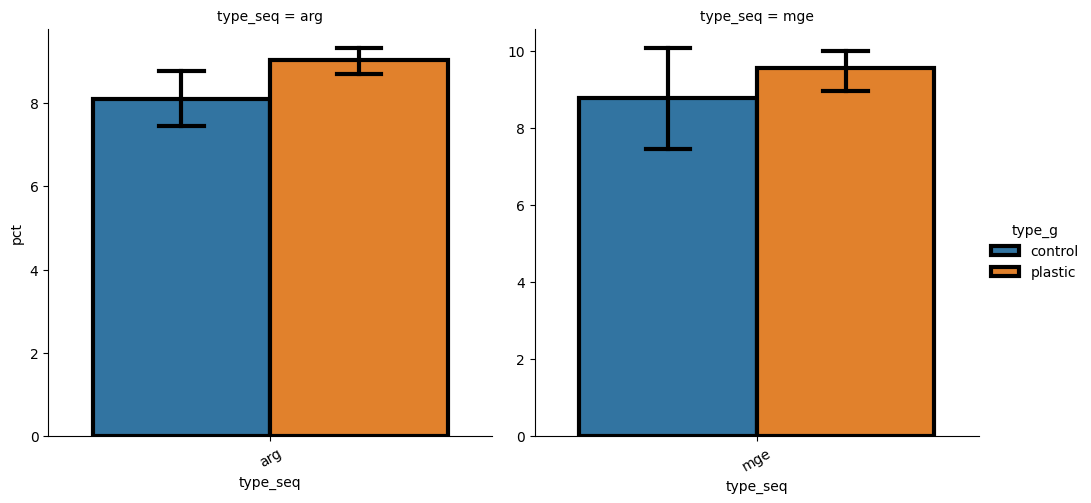

In [36]:
plt.figure(figsize=(2,4))
lala = sns.catplot(data=test, 
                   x="type_seq", y="pct", 
                   col="type_seq", hue = "type_g",
                   kind = "bar", 
                   sharey = False, sharex = False,
                   errorbar=("ci", 95), capsize=.1, errcolor="black", errwidth = 3,
                   linewidth=3, edgecolor="black")
lala.set_xticklabels(rotation=30);

## COMPARATIVA A NIVEL DE GEN INDIVIDUAL

Así a botepronto, me da la impresión de que estudiar la presencia/ausencia a nivel de gen individual no va a mostrar diferencia con respecto a estudiar la media del nº de copia, pero lo hago igualmente porsiaca

In [37]:
# Sacar todos los datos, incluyendo los no amplificados de todas las muestras
amp_data = pd.read_csv("../data/clean_data/ab_data_all.csv", index_col = 0)
amp_data["rel_n"] = amp_data["rel_n"].fillna(0)
qtest = amp_data[["Assay", "rel_n", "type_g"]] #quedarme sólo con las columnas de interés

qtest.loc[qtest["rel_n"] > 0, "rel_n"] = 1 #convertir rel_n en una columna binaria de detección/no detección



del amp_data
count = 0
for seq_name, seq_group in qtest.groupby("Assay"): #por cada par control/plástico
    
    plas = seq_group.loc[seq_group["type_g"] == "plastic"]["rel_n"]
    control = seq_group.loc[seq_group["type_g"] == "control"]["rel_n"]
    
    normality_plas = stats.shapiro(x = plas)[1] 
    normality_control = stats.shapiro(x = control)[1]
    normality = normality_control + normality_plas #para simplificar
    if normality >= 0.1: #ambos > 0.05 para satisfacer esta condición
        norm = True
        #print("Both normal")
        homocedasticity = stats.levene(plas, control, center = "mean")[1]
    else: 
        norm = False
        homocedasticity = stats.levene(plas, control, center = "median")[1]
    if (homocedasticity >= 0.05) and (norm == True): 
        result = stats.ttest_ind(a = plas, b = control,
                                 equal_var = True, alternative = "greater")
    
    elif (homocedasticity > 0.05): #homocedásticos no normales
        result = stats.mannwhitneyu(x = plas, y = control, alternative = "greater")
    
    elif (homocedasticity < 0.05) and (norm == True):
        result = stats.ttest_ind(a = plas, b = control, alternative = "greater", equal_var = False)
        result = ("Welch!", result[1], result[0])
    else: #todo mal, permuta
        result = stats.permutation_test(data = (plas, control), statistic =  statistic_mean, 
                                        vectorized = True, n_resamples = 20000,
                                        alternative = "greater", permutation_type = "independent")
        result = ("Permutation", result.pvalue, result.statistic) #ugly hack!
    if result[1] < 0.05:
        count += 1
        print("############", seq_name, "############", count)
        print(result)
        print("")
    
    
    #print(plas.Assay.unique())
    
    #if count ==5: break
    

############ ArmA ############ 1
('Welch!', 0.004486368738611661, 3.0)

############ EAE_05855 ############ 2
('Welch!', 0.004486368738611661, 3.0)

############ IS1111 ############ 3
('Welch!', 0.041265353173481116, 1.8605210188381267)

############ IS200a ############ 4
('Welch!', 0.004486368738611661, 3.0)

############ IS6100 ############ 5
('Welch!', 0.009828517270855586, 2.6111648393354674)

############ IS91 ############ 6
('Welch!', 0.00026286539496973903, 4.391550328268399)

############ ISPps1-pseud ############ 7
('Welch!', 0.004486368738611661, 3.0)

############ IncW_trwAB ############ 8
('Welch!', 0.004486368738611661, 3.0)

############ NDM new ############ 9
('Welch!', 0.004486368738611661, 3.0)

############ TN5403 ############ 10
('Welch!', 0.0019163511439152952, 3.415650255319866)

############ Tn3 ############ 11
('Welch!', 0.004486368738611661, 3.0)

############ VanB ############ 12
MannwhitneyuResult(statistic=107.0, pvalue=0.04041931029975878)

############ aac(

In [38]:
# Misma historia, pero para ver cuáles menos
for seq_name, seq_group in qtest.groupby("Assay"): #por cada par control/plástico
    
    plas = seq_group.loc[seq_group["type_g"] == "plastic"]["rel_n"]
    control = seq_group.loc[seq_group["type_g"] == "control"]["rel_n"]
    
    normality_plas = stats.shapiro(x = plas)[1] 
    normality_control = stats.shapiro(x = control)[1]
    normality = normality_control + normality_plas #para simplificar
    if normality >= 0.1: #ambos > 0.05 para satisfacer esta condición
        norm = True
        #print("Both normal")
        homocedasticity = stats.levene(plas, control, center = "mean")[1]
    else: 
        norm = False
        homocedasticity = stats.levene(plas, control, center = "median")[1]
    if (homocedasticity >= 0.05) and (norm == True): 
        result = stats.ttest_ind(a = plas, b = control,
                                 equal_var = True, alternative = "less")
    
    elif (homocedasticity > 0.05): #homocedásticos no normales
        result = stats.mannwhitneyu(x = plas, y = control, alternative = "less")
    
    elif (homocedasticity < 0.05) and (norm == True):
        result = stats.ttest_ind(a = plas, b = control, alternative = "less", equal_var = False)
        result = ("Welch!", result[1], result[0])
    else: #todo mal, permuta
        result = stats.permutation_test(data = (plas, control), statistic =  statistic_mean, 
                                        vectorized = True, n_resamples = 20000,
                                        alternative = "less", permutation_type = "independent")
        result = ("Permutation", result.pvalue, result.statistic) #ugly hack!
    if result[1] < 0.05:
        print("############", seq_name, "############")
        print(result)
        print("")
    
    
    #print(plas.Assay.unique())
    #count += 1
    #if count ==5: break
    